In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

from tensorflow.examples.tutorials.mnist import input_data



mnist = input_data.read_data_sets('datasets/MNIST_data', one_hot=True)
input_dim = mnist.train.images[0].shape[0]
output_dim = 10
h_image=28
w_image=28

Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
num_conv_layers = 10
tf.reset_default_graph()

## INPUT AND OUTPUT PLACEHOLDER
input_placeholder = tf.placeholder(dtype=tf.float32, 
                                   shape=[None, input_dim],
                                    name='inputplaceholder')
output_placeholder = tf.placeholder(dtype=tf.float32, 
                                   shape=[None, output_dim],
                                    name='outputplaceholder')


reshaped_input = tf.reshape(input_placeholder, [-1, h_image, w_image, 1])
conv1 = tf.layers.conv2d(reshaped_input, 32, [3,3], activation=tf.nn.relu, name="conv1")
conv1_mp = tf.layers.max_pooling2d(conv1, [2,2], [2,2])
conv2 = tf.layers.conv2d(conv1_mp, 32, [3,3], activation=tf.nn.relu, name="conv2")
conv2_mp = tf.layers.max_pooling2d(conv2, [2,2], [2,2])
conv3 = tf.layers.conv2d(conv2_mp, 32, [3,3], activation=tf.nn.relu, name="conv3")

flattened = tf.contrib.layers.flatten(conv3)
print(flattened)
output = tf.layers.dense(flattened, output_dim, activation=None)
print(output)
loss = tf.losses.sigmoid_cross_entropy(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Tensor("Flatten/Reshape:0", shape=(?, 288), dtype=float32)
Tensor("dense/BiasAdd:0", shape=(?, 10), dtype=float32)
INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


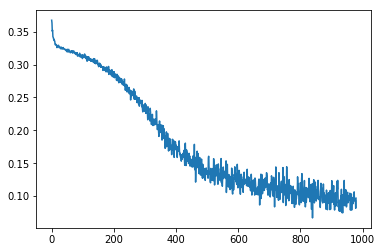

In [3]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

iterations = 1000
batch_size = 128
loss_history = list()
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, l = sess.run([optimizer, loss],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    loss_history.append(l)

plt.plot(loss_history[20:])
plt.show()
no_do_loss_history = loss_history


### What is Tensorboard?
By now you probably noticed that building a model and training a neural network can be a lot of fidgeting with hyper parameters and layers. Sometimes it can be difficult to see the performance between two models, and debugging models is often difficult. A tool that really helps you with this is Tensorboard: a web application that reads event files you can write away with TensorFlow. 


### Starting Tensorboard
When you ran `docker-compose up` you not only started a virtual operating system with Tensorflow and Jupyter notebook, but also started a server that runs Tensorboard. Tensorboard is now accessible by navigating to `localhost:6006`. As we did not use it yet, you will probably see the following screen: 

XXX IMAGE OF AN EMPTY SCREEN HERE XXX

This is because we did not write anything yet. 

### Writing your graph

To write your graph (and any other data) you have to initialize a Filewrite object. The constructor requires you to give the name of the directory you want to log in, and the graph you want to use for this writer. 

During this course we write everything to the graphs directory (as Tensorboard looks in this directory). Apart from the we make a directory per section during this course. After you did this there is one more thing remaining: it is good practice to put each model you make (every time you change something you have a new model) in a separate folder. You will see later why this is useful. Now let's start by starting a FileWriter:

In [4]:
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/firstwriter' , graph=tf.get_default_graph())
writer.flush()

If you wait a while, or refresh the Tensorboard page, you should be able to navigate to the Graphs tab, and visualise your graph:

XXXX IMAGE HERE OF FIRST GRAPH XXX

The gradients block makes everything a bit difficult to inspect, so you can remove this: 

XXXX IMAGE HERE OF REMOVING IT XXX

## Video 2: Adding summaries

Now that we are able to get our graph in Tensorboard it's time to add something more interesting: the loss. Right now we are working with Matplotlib, and either have to store the losses somewhere, or have to figure out what model works better...

With Tensorboard we can simply improve on this by using multiple logging directories. Especially with a Jupyter Notebook doing this is easy. Here is my normal working routing when trying to build a good neural network: 
- Determine in what directory I will log, set a variable to zero
- Build a (simple) initial graph
- Write things to a directory (and increment variable by one for next time)
- Adjust network!

Let's start with the first step, and set a variable to zero and make a directory: 

In [5]:
logging_dir_n = 0 


### Actually logging something
So far we did not log anything, we can do so by adding a scalar summary of the loss value. Note that instead of the next block I do this in the block after that: 

In [6]:
tf.reset_default_graph()

input_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, input_dim], name='inputplaceholder')
output_placeholder = tf.placeholder(dtype=tf.float32, shape=[None, output_dim], name='outputplaceholder')

reshaped_input = tf.reshape(input_placeholder, [-1, h_image, w_image, 1])
conv1 = tf.layers.conv2d(reshaped_input, 32, [3,3], activation=tf.nn.relu, name="conv1")
conv1_mp = tf.layers.max_pooling2d(conv1, [2,2], [2,2])
conv2 = tf.layers.conv2d(conv1_mp, 32, [3,3], activation=tf.nn.relu, name="conv2")
conv2_mp = tf.layers.max_pooling2d(conv2, [2,2], [2,2])
conv3 = tf.layers.conv2d(conv2_mp, 32, [3,3], activation=tf.nn.relu, name="conv3")

flattened = tf.contrib.layers.flatten(conv3)
output = tf.layers.dense(flattened, output_dim, activation=None)

loss = tf.losses.sigmoid_cross_entropy(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [7]:
loss_summary = tf.summary.scalar('loss', loss)

In [8]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1


### Writing to the summary
Instead of asking the graph to give me the loss each iteration I now ask the graph to give me the summary of the loss. I collect all summaries and add them to my writer...

In [9]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)


### Adjusting your graph
Now that we have a first loss we can adjust our graph, and see if the loss improves (or becomes worse...). 

In [10]:
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [11]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1


## Video 3: inspecting weights

Let's say that you totally misinterpreted the learning rate: 

In [12]:
loss = tf.losses.mean_squared_error(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(5.0).minimize(loss)


In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)


Looking at Tensorboard you now see the loss go up, but you have no idea why. The graph looks really good (no wrong passes...), but you clearly see your loss going up. 

Now is a good time to either inspect your gradients, inspect activations, or inspect your weights. Let's take weights for example: 


In [14]:
## Print variable names; 
for v in tf.global_variables():
    print(v.name)
    
histograms = []
for v in tf.global_variables():
    if "kernel" in v.name:
        toadd = tf.summary.histogram(v.name[:-2], v)
        histograms.append(toadd)

conv1/kernel:0
conv1/bias:0
conv2/kernel:0
conv2/bias:0
conv3/kernel:0
conv3/bias:0
dense/kernel:0
dense/bias:0
beta1_power:0
beta2_power:0
conv1/kernel/Adam:0
conv1/kernel/Adam_1:0
conv1/bias/Adam:0
conv1/bias/Adam_1:0
conv2/kernel/Adam:0
conv2/kernel/Adam_1:0
conv2/bias/Adam:0
conv2/bias/Adam_1:0
conv3/kernel/Adam:0
conv3/kernel/Adam_1:0
conv3/bias/Adam:0
conv3/bias/Adam_1:0
dense/kernel/Adam:0
dense/kernel/Adam_1:0
dense/bias/Adam:0
dense/bias/Adam_1:0


In [15]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [16]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    weights_in_graph = sess.run(histograms)
    for logged_weight in weights_in_graph: 
        writer.add_summary(logged_weight, iteration)

InvalidArgumentError: Nan in summary histogram for: dense/kernel_1
	 [[Node: dense/kernel_1 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](dense/kernel_1/tag, dense/kernel/read)]]

Caused by op 'dense/kernel_1', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-ca50824e2a15>", line 8, in <module>
    toadd = tf.summary.histogram(v.name[:-2], v)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/summary/summary.py", line 192, in histogram
    tag=tag, values=values, name=scope)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_logging_ops.py", line 129, in _histogram_summary
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Nan in summary histogram for: dense/kernel_1
	 [[Node: dense/kernel_1 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](dense/kernel_1/tag, dense/kernel/read)]]


### Comparing it to a "normal" situation
Now let's compare this to a "normal" situation, where we hopefully don't see all weights explode:

In [17]:
loss = tf.losses.mean_squared_error(output_placeholder, output)
optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [18]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, loss_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    weights_in_graph = sess.run(histograms)
    for logged_weight in weights_in_graph: 
        writer.add_summary(logged_weight, iteration)

## Video 4: inspecting input/output
You can even use TensorBoard to show your input and outputs. Use the image summary to add an image to Tensorboard. This can help you when your network is not learning anything: it might just be possible that your network is not receiving any sensible input at all!

In [19]:
image_summary = tf.summary.image('inputimage', reshaped_input)

In [20]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [21]:
for iteration in range(10):
    batch = mnist.train.next_batch(batch_size)
    _, summary, im_sum = sess.run([optimizer, loss_summary, image_summary],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    writer.add_summary(im_sum, iteration)

### Merging summaries
Right now we ask for each summary separately in our session. Luckily Tensorboard can improve on this by using the following function: 

In [22]:
merged = tf.summary.merge_all()

In [23]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter(logdir='graphs/tensorboardexplanation/tutorial/'+str(logging_dir_n) , graph=tf.get_default_graph())
logging_dir_n += 1

In [24]:
for iteration in range(iterations):
    batch = mnist.train.next_batch(batch_size)
    _, summary = sess.run([optimizer, merged],
                                feed_dict={input_placeholder: batch[0], output_placeholder: batch[1]})
    writer.add_summary(summary, iteration)
    

### Conclusion
We are now logging all summaries we defined to Tensorboard! You can define way more things you want to log, like the accuracy of your network, other loss functions, activations in different layers, whatever you want! We will use Tensorboard in the next section, so you can easily tinker with your graph and see how well it improves the performance. 